In [2]:
import gzip 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps

%cd "/data/groups/ag_kircher/"


/fast/home/groups/ag_kircher


In [3]:
sample = 'IH01'

# Load fft, coverage, wps data 

In [10]:
##load fft summary
fft = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/fft_normalised.tsv" %sample, header = 0, sep = "\t", index_col = 0) 
#fft = fft[['205','202','199','196','193','190','187','185','182','180','177','175','173','170','168','166']]

##load coverage -1kb to 1kb around TSS
coverage_body = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/cov_normalised.tsv" %sample, sep = '\t', header = None, index_col = 0)

##load wps -1kb to 1kb around TSS
wps_body = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/wps_normalised.tsv" %sample, sep = '\t',header = None, index_col = 0)


In [11]:
coverage_2k

,1,2,3,4,5,6,7,8,9,10,...,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
0,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,0.7201,0.7201,0.7201,0.7201,0.7201,0.7449,0.7449,0.7449,0.7449,0.7449,...,0.5711,0.5711,0.5463,0.5463,0.5463,0.5463,0.5463,0.5959,0.5959,0.5959
ENSG00000000005,0.6952,0.6952,0.6952,0.7201,0.7201,0.7201,0.6704,0.6704,0.6704,0.7449,...,0.6952,0.6952,0.6952,0.6952,0.7201,0.7201,0.6952,0.6952,0.6952,0.6952
ENSG00000000419,0.0745,0.0745,0.0745,0.0745,0.0745,0.0745,0.0745,0.0745,0.0745,0.0745,...,1.0677,1.0429,1.0429,1.0429,1.0429,1.0429,1.0429,1.0677,1.0677,1.0677
ENSG00000000457,0.1490,0.1490,0.1490,0.1490,0.1490,0.1490,0.1490,0.1490,0.1490,0.1490,...,0.7449,0.7201,0.7201,0.7201,0.7449,0.7449,0.6704,0.6704,0.6704,0.6456
ENSG00000000460,0.2483,0.2483,0.2483,0.2483,0.2483,0.2731,0.2731,0.2483,0.2483,0.2483,...,1.2415,1.2415,1.2415,1.2415,1.2415,1.2415,1.2415,1.2415,1.2167,1.2167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000273173,0.5711,0.5711,0.5463,0.5463,0.5711,0.5711,0.5463,0.5214,0.5463,0.5463,...,0.8690,0.8442,0.8442,0.8442,0.8442,0.8442,0.8442,0.8690,0.8690,0.8690
ENSG00000273217,0.1241,0.1241,0.1241,0.1241,0.1241,0.1241,0.1241,0.0745,0.0745,0.0745,...,0.7946,0.7946,0.7946,0.7946,0.7946,0.7946,0.7946,0.8194,0.8194,0.8194
ENSG00000273238,0.9187,1.1670,1.2415,1.2663,1.2912,1.2912,1.2912,1.2912,1.2912,1.2912,...,1.1173,1.1173,1.2663,1.2663,1.2663,1.2663,1.2663,1.2663,1.2663,1.2663


In [30]:
display(wps_2k.shape)
display(coverage_2k.shape)
display(fft.shape)

(19079, 2001)

(19079, 2001)

(19078, 16)

# Load and filter expression data 

In [31]:
##load monocyte expression data 
expressionData = pd.read_csv("cfDNA-reanalysis_Graz/kristin/cfDNA/resources/protein_atlas/RNAtableExtended.tsv.gz", index_col = 0 ,compression = "gzip", header = 0, sep = "\t")
expressionMonocyte = expressionData[['monocytes']]


In [32]:
##load genes with high IQR 
genesHighIqr = pd.read_csv("cfDNA-reanalysis_Graz/kristin/GenesHighIQR.tsv", header = 0, sep = "\t")
genesHighIqr.index = genesHighIqr["GeneID"]
genesHighIqr = genesHighIqr.drop("GeneID", axis = 1)
genesHighIqr

,var,iqr
GeneID,,
ENSG00000000003,170.847323,10.475
ENSG00000000419,90.157589,13.025
ENSG00000000457,18.299025,6.925
ENSG00000000460,29.738018,7.700
ENSG00000000938,187.132559,4.175
...,...,...
ENSG00000285304,18.725094,5.000
ENSG00000285330,176.037722,1.700
ENSG00000285382,3.782850,2.800


In [33]:
#log transform expression values
LogExpressionMonocyte = expressionMonocyte.copy()
LogExpressionMonocyte['monocytes'] = np.log2(LogExpressionMonocyte['monocytes'] + 1)
LogExpressionMonocyte

,monocytes
GeneID,
ENSG00000000003,0.263034
ENSG00000000005,0.000000
ENSG00000000419,4.364572
ENSG00000000457,2.405992
ENSG00000000460,2.560715
...,...
ENSG00000285471,0.000000
ENSG00000285472,0.000000
ENSG00000285480,0.485427


In [35]:
import matplotlib.pyplot as plt


Expressed = LogExpressionMonocyte[(LogExpressionMonocyte.monocytes > 0.75)]
NotExpressed = LogExpressionMonocyte[(LogExpressionMonocyte.monocytes <= 0.75)].sample(frac = 0.2, random_state = 1)

LogExpressionFiltered = Expressed.append(NotExpressed)


# Merge datasets by gene ids 

In [54]:
union = LogExpressionFiltered.index.intersection(genesHighIqr.index).intersection(fft.index)


In [55]:
##filter high iqr genes ids 

LogExpressionFilteredIQR = LogExpressionFiltered.loc[union]

fft = fft.loc[union]
coverage_2k = coverage_2k.loc[union]
wps_2k = wps_2k.loc[union]


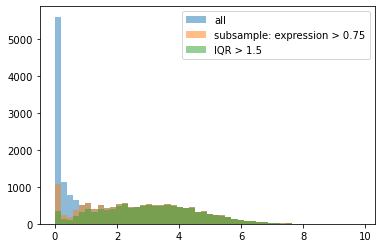

In [56]:
plt.hist(LogExpressionMonocyte, alpha = 0.5, bins = 50, label = "all")
plt.hist(LogExpressionFiltered['monocytes'], alpha = 0.5, bins = 50, label = "subsample: expression > 0.75")
plt.hist(LogExpressionFilteredIQR['monocytes'], alpha = 0.5, bins = 50, label = "IQR > 1.5")
plt.legend(loc='upper right')
plt.show()

In [39]:
display(LogExpressionFilteredIQR.shape)
display(wps_2k.shape)
display(coverage_2k.shape)
display(fft.shape)

(11276, 1)

(11276, 2001)

(11276, 2001)

(11276, 16)

# Calculate features

## Mean, median, variance

In [57]:
##generate dataframe with features

features = fft.copy()

features['mean_cov_body1kb'] = coverage_2k.loc[:,1000:2000].mean(axis = 1)
features['median_cov_body1kb'] = coverage_2k.loc[:,1000:2000].median(axis = 1)
features['var_cov_body1kb'] = coverage_2k.loc[:,1000:2000].var(axis = 1)
features['mean_cov_upstream1kb'] = coverage_2k.loc[:,0:1000].mean(axis = 1)
features['median_cov_upstream1kb'] = coverage_2k.loc[:,0:1000].median(axis = 1)
features['var_cov_upstream1kb'] = coverage_2k.loc[:,0:1000].var(axis = 1)

features['variance_cov_2k'] = coverage_2k.loc[:,0:2000].var(axis = 1)
features['mean_cov_2k'] = coverage_2k.loc[:,0:2000].mean(axis = 1)
features['median_cov_2k'] = coverage_2k.loc[:,0:2000].median(axis = 1)

features['mean_wps_body1kb'] = wps_2k.loc[:,1000:2000].mean(axis = 1)
features['median_wps_body1kb'] = wps_2k.loc[:,1000:2000].median(axis = 1)
features['var_wps_body1kb'] = wps_2k.loc[:,1000:2000].var(axis = 1)

features['mean_wps_upstream1kb'] = wps_2k.loc[:,0:1000].mean(axis = 1)
features['median_wps_upstream1kb'] = wps_2k.loc[:,0:1000].median(axis = 1)
features['var_wps_upstream1kb'] = wps_2k.loc[:,0:1000].var(axis = 1)

features['variance_wps_2k'] = wps_2k.loc[:,0:2000].var(axis = 1)
features['mean_wps_2k'] = wps_2k.loc[:,0:2000].mean(axis = 1)
features['median_wps_2k'] = wps_2k.loc[:,0:2000].median(axis = 1)



features

,205,202,199,196,193,190,187,185,182,180,...,median_cov_2k,mean_wps_body1kb,median_wps_body1kb,var_wps_body1kb,mean_wps_upstream1kb,median_wps_upstream1kb,var_wps_upstream1kb,variance_wps_2k,mean_wps_2k,median_wps_2k
ENSG00000000419,1.059186e+05,1.441095e+05,1.729631e+05,1.652304e+05,1.770189e+05,3.273326e+05,9.866744e+05,1.470564e+06,9.134236e+05,3.593131e+05,...,17.0,-25.439560,-25.0,219.406593,-14.490,-14.0,62.280180,170.878009,-19.9695,-18.0
ENSG00000000457,3.851056e+05,2.277518e+05,7.871784e+04,5.645857e+04,5.478378e+05,2.009344e+06,2.850412e+06,2.568356e+06,3.036212e+06,3.008914e+06,...,14.0,-16.835165,-13.0,135.297802,-21.599,-21.0,195.753953,171.137728,-19.2210,-17.0
ENSG00000000460,1.960667e+05,1.865991e+05,2.736185e+05,7.287775e+05,9.439920e+05,7.624418e+05,9.654935e+05,8.737578e+05,3.281773e+05,1.810284e+05,...,23.0,-32.052947,-35.0,211.650194,-25.663,-24.0,122.592023,177.360799,-28.8590,-28.0
ENSG00000000938,9.405659e+04,5.895011e+04,4.804570e+04,1.131751e+05,2.105715e+05,1.993286e+05,1.076453e+05,9.611329e+04,1.192243e+05,7.359413e+04,...,12.0,-15.372627,-15.0,19.776010,-16.761,-16.0,93.038918,56.870946,-16.0670,-15.0
ENSG00000001036,4.222304e+05,5.417112e+05,6.120958e+05,6.200426e+05,5.490061e+05,3.123375e+05,1.012305e+05,6.352054e+04,1.115361e+05,1.657148e+05,...,23.0,-20.864136,-20.0,90.821522,-37.174,-39.0,384.077802,303.937800,-29.0130,-26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000126217,2.613140e+06,6.049776e+06,6.235625e+06,2.885246e+06,5.988100e+05,4.668757e+05,5.607743e+05,3.457328e+05,3.043622e+05,3.085756e+05,...,24.0,-39.031968,-40.0,272.970977,-28.288,-24.0,248.909966,289.740140,-33.6695,-29.0
ENSG00000109956,4.345992e+05,4.642708e+05,3.215901e+05,2.511354e+05,3.179019e+05,4.520626e+05,5.475770e+05,4.925015e+05,2.988405e+05,1.286824e+05,...,19.0,-36.332667,-32.0,413.070222,-14.081,-11.0,115.634073,388.308498,-25.2160,-22.0
ENSG00000206538,1.373026e+06,1.165613e+06,1.189674e+06,1.392477e+06,1.317819e+06,1.074638e+06,7.407984e+05,3.447213e+05,8.131513e+04,1.941261e+04,...,31.0,-32.799201,-31.0,389.180639,-38.497,-38.0,206.220211,305.823960,-35.6515,-34.0
ENSG00000185272,1.134965e+05,1.690197e+05,2.639605e+05,5.693314e+05,7.988955e+05,7.103865e+05,6.352872e+05,6.492076e+05,4.586534e+05,2.025019e+05,...,34.5,-36.431568,-36.0,214.509562,-44.074,-39.0,412.665189,328.066227,-40.2575,-37.0


## Amplitudes, ndr width 

In [191]:
wps_2k_smoothed = wps_2k.copy()

for gene in wps_2k_smoothed.index: 
    wps_2k_smoothed.loc[gene] = sps.savgol_filter(wps_2k.loc[gene], window_length = 65, polyorder = 3)

In [192]:
wps_2k_smoothed.to_csv('cfDNA-reanalysis_Graz/kristin/rf_model/%s/table_WPS_2k_smoothed.csv' %sample, sep = '\t', header = True)

In [58]:
wps_2k_smoothed = pd.read_csv("cfDNA-reanalysis_Graz/kristin/rf_model/%s/table_WPS_2k_smoothed.csv" %sample, sep = "\t", index_col = 0, header = 0) 

In [59]:
wps_2k_smoothed.columns = list(range(1,2002))

In [60]:
features['amp1'] = 0
features['amp2'] = 0 
features['ndr_width1'] = 0
features['ndr_width2'] = 0 

In [61]:
import numpy as np
import math

for gene in wps_2k_smoothed.index:

    print(gene)
    
    ##calculate amplitudes
    row = wps_2k_smoothed.loc[gene,1000:2000]

    maxima = np.array(sps.argrelextrema(np.array(row), comparator = np.greater, order = 50)).flatten()
    minima = np.array(sps.argrelextrema(np.array(row), comparator = np.less, order = 50)).flatten()
 
    amp1 = max(row.iloc[maxima[0]] - row.iloc[minima[0]], row.iloc[minima[0]] - row.iloc[maxima[0]])
    amp2 = max(row.iloc[maxima[1]] - row.iloc[minima[1]], row.iloc[minima[1]] - row.iloc[maxima[1]])
    
    features.loc[gene,'amp1'] = amp1
    features.loc[gene,'amp2'] = amp2
    
    ##calculate peak distances 
    row = wps_2k_smoothed.loc[gene,]
    
    max_peaks = np.array(sps.argrelextrema(np.array(row), comparator = np.greater, order = 50)).flatten()
    peak1_upstream = max(list(filter(lambda x: x < 1000, max_peaks)))
    peak1_body = min(list(filter(lambda x: x > 1000, max_peaks)))
    peak2_body = list(filter(lambda x: x > 1000, max_peaks))[1]

    features.loc[gene, 'ndr_width1'] = int(peak1_body) - int(peak1_upstream)
    features.loc[gene, 'ndr_width2'] = int(peak2_body) - int(peak1_upstream)

ENSG00000000419
ENSG00000000457
ENSG00000000460
ENSG00000000938
ENSG00000001036
ENSG00000001084
ENSG00000001167
ENSG00000001460
ENSG00000001461
ENSG00000001497
ENSG00000001561
ENSG00000001629
ENSG00000001630
ENSG00000001631
ENSG00000002016
ENSG00000002330
ENSG00000002549
ENSG00000002586
ENSG00000002822
ENSG00000002834
ENSG00000002919
ENSG00000002933
ENSG00000003056
ENSG00000003147
ENSG00000003393
ENSG00000003400
ENSG00000003402
ENSG00000003509
ENSG00000003756
ENSG00000004059
ENSG00000004139
ENSG00000004142
ENSG00000004399
ENSG00000004455
ENSG00000004468
ENSG00000004478
ENSG00000004487
ENSG00000004534
ENSG00000004660
ENSG00000004700
ENSG00000004766
ENSG00000004779
ENSG00000004799
ENSG00000004864
ENSG00000004866
ENSG00000004897
ENSG00000004961
ENSG00000004975
ENSG00000005007
ENSG00000005020
ENSG00000005022
ENSG00000005059
ENSG00000005075
ENSG00000005100
ENSG00000005156
ENSG00000005175
ENSG00000005187
ENSG00000005194
ENSG00000005206
ENSG00000005238
ENSG00000005243
ENSG00000005249
ENSG0000

ENSG00000059728
ENSG00000059758
ENSG00000059769
ENSG00000059804
ENSG00000060069
ENSG00000060138
ENSG00000060237
ENSG00000060339
ENSG00000060491
ENSG00000060558
ENSG00000060642
ENSG00000060688
ENSG00000060749
ENSG00000060762
ENSG00000060971
ENSG00000060982
ENSG00000061273
ENSG00000061656
ENSG00000061794
ENSG00000061918
ENSG00000061936
ENSG00000061938
ENSG00000061987
ENSG00000062194
ENSG00000062282
ENSG00000062370
ENSG00000062485
ENSG00000062582
ENSG00000062598
ENSG00000062650
ENSG00000062716
ENSG00000062725
ENSG00000062822
ENSG00000063046
ENSG00000063176
ENSG00000063177
ENSG00000063180
ENSG00000063241
ENSG00000063244
ENSG00000063245
ENSG00000063322
ENSG00000063587
ENSG00000063601
ENSG00000063761
ENSG00000063854
ENSG00000063978
ENSG00000064012
ENSG00000064102
ENSG00000064115
ENSG00000064199
ENSG00000064225
ENSG00000064313
ENSG00000064393
ENSG00000064419
ENSG00000064490
ENSG00000064545
ENSG00000064547
ENSG00000064601
ENSG00000064607
ENSG00000064651
ENSG00000064652
ENSG00000064666
ENSG0000

ENSG00000083635
ENSG00000083642
ENSG00000083720
ENSG00000083750
ENSG00000083799
ENSG00000083807
ENSG00000083812
ENSG00000083814
ENSG00000083817
ENSG00000083828
ENSG00000083838
ENSG00000083844
ENSG00000083845
ENSG00000083896
ENSG00000083937
ENSG00000084070
ENSG00000084072
ENSG00000084073
ENSG00000084090
ENSG00000084092
ENSG00000084093
ENSG00000084112
ENSG00000084207
ENSG00000084234
ENSG00000084444
ENSG00000084463
ENSG00000084623
ENSG00000084652
ENSG00000084676
ENSG00000084693
ENSG00000084733
ENSG00000084754
ENSG00000084764
ENSG00000084774
ENSG00000085063
ENSG00000085117
ENSG00000085185
ENSG00000085224
ENSG00000085231
ENSG00000085265
ENSG00000085274
ENSG00000085276
ENSG00000085365
ENSG00000085377
ENSG00000085382
ENSG00000085415
ENSG00000085433
ENSG00000085449
ENSG00000085491
ENSG00000085511
ENSG00000085514
ENSG00000085644
ENSG00000085662
ENSG00000085719
ENSG00000085721
ENSG00000085760
ENSG00000085788
ENSG00000085832
ENSG00000085871
ENSG00000085872
ENSG00000085978
ENSG00000085982
ENSG0000

ENSG00000100813
ENSG00000100814
ENSG00000100815
ENSG00000100823
ENSG00000100836
ENSG00000100852
ENSG00000100865
ENSG00000100883
ENSG00000100888
ENSG00000100889
ENSG00000100890
ENSG00000100897
ENSG00000100902
ENSG00000100906
ENSG00000100908
ENSG00000100911
ENSG00000100916
ENSG00000100918
ENSG00000100926
ENSG00000100934
ENSG00000100938
ENSG00000100941
ENSG00000100949
ENSG00000100979
ENSG00000100982
ENSG00000100983
ENSG00000100991
ENSG00000100994
ENSG00000100997
ENSG00000101000
ENSG00000101003
ENSG00000101017
ENSG00000101019
ENSG00000101040
ENSG00000101052
ENSG00000101079
ENSG00000101084
ENSG00000101096
ENSG00000101109
ENSG00000101126
ENSG00000101132
ENSG00000101138
ENSG00000101146
ENSG00000101150
ENSG00000101152
ENSG00000101158
ENSG00000101160
ENSG00000101161
ENSG00000101166
ENSG00000101181
ENSG00000101182
ENSG00000101189
ENSG00000101190
ENSG00000101191
ENSG00000101193
ENSG00000101194
ENSG00000101199
ENSG00000101213
ENSG00000101216
ENSG00000101220
ENSG00000101224
ENSG00000101236
ENSG0000

ENSG00000105821
ENSG00000105829
ENSG00000105835
ENSG00000105849
ENSG00000105851
ENSG00000105854
ENSG00000105856
ENSG00000105865
ENSG00000105866
ENSG00000105875
ENSG00000105879
ENSG00000105887
ENSG00000105926
ENSG00000105928
ENSG00000105939
ENSG00000105948
ENSG00000105953
ENSG00000105963
ENSG00000105967
ENSG00000105968
ENSG00000105983
ENSG00000105991
ENSG00000105993
ENSG00000105997
ENSG00000106003
ENSG00000106009
ENSG00000106012
ENSG00000106028
ENSG00000106034
ENSG00000106049
ENSG00000106052
ENSG00000106066
ENSG00000106069
ENSG00000106077
ENSG00000106080
ENSG00000106086
ENSG00000106100
ENSG00000106105
ENSG00000106123
ENSG00000106144
ENSG00000106153
ENSG00000106211
ENSG00000106244
ENSG00000106245
ENSG00000106246
ENSG00000106261
ENSG00000106263
ENSG00000106266
ENSG00000106268
ENSG00000106290
ENSG00000106299
ENSG00000106305
ENSG00000106330
ENSG00000106333
ENSG00000106344
ENSG00000106346
ENSG00000106348
ENSG00000106355
ENSG00000106367
ENSG00000106392
ENSG00000106397
ENSG00000106399
ENSG0000

ENSG00000112149
ENSG00000112159
ENSG00000112167
ENSG00000112200
ENSG00000112234
ENSG00000112237
ENSG00000112242
ENSG00000112245
ENSG00000112249
ENSG00000112282
ENSG00000112290
ENSG00000112297
ENSG00000112303
ENSG00000112304
ENSG00000112305
ENSG00000112306
ENSG00000112308
ENSG00000112312
ENSG00000112335
ENSG00000112339
ENSG00000112343
ENSG00000112357
ENSG00000112365
ENSG00000112367
ENSG00000112406
ENSG00000112419
ENSG00000112425
ENSG00000112473
ENSG00000112514
ENSG00000112530
ENSG00000112531
ENSG00000112561
ENSG00000112576
ENSG00000112578
ENSG00000112584
ENSG00000112592
ENSG00000112624
ENSG00000112640
ENSG00000112651
ENSG00000112658
ENSG00000112659
ENSG00000112667
ENSG00000112679
ENSG00000112685
ENSG00000112695
ENSG00000112697
ENSG00000112699
ENSG00000112701
ENSG00000112715
ENSG00000112739
ENSG00000112759
ENSG00000112763
ENSG00000112773
ENSG00000112787
ENSG00000112799
ENSG00000112851
ENSG00000112855
ENSG00000112874
ENSG00000112877
ENSG00000112893
ENSG00000112941
ENSG00000112972
ENSG0000

ENSG00000118816
ENSG00000118849
ENSG00000118855
ENSG00000118873
ENSG00000118894
ENSG00000118900
ENSG00000118939
ENSG00000118960
ENSG00000118961
ENSG00000118971
ENSG00000118985
ENSG00000119004
ENSG00000119013
ENSG00000119041
ENSG00000119042
ENSG00000119048
ENSG00000119125
ENSG00000119138
ENSG00000119139
ENSG00000119185
ENSG00000119203
ENSG00000119227
ENSG00000119231
ENSG00000119242
ENSG00000119280
ENSG00000119285
ENSG00000119314
ENSG00000119318
ENSG00000119321
ENSG00000119328
ENSG00000119333
ENSG00000119335
ENSG00000119383
ENSG00000119392
ENSG00000119396
ENSG00000119397
ENSG00000119401
ENSG00000119402
ENSG00000119403
ENSG00000119408
ENSG00000119414
ENSG00000119421
ENSG00000119431
ENSG00000119446
ENSG00000119471
ENSG00000119487
ENSG00000119509
ENSG00000119522
ENSG00000119523
ENSG00000119535
ENSG00000119537
ENSG00000119541
ENSG00000119559
ENSG00000119574
ENSG00000119596
ENSG00000119599
ENSG00000119616
ENSG00000119630
ENSG00000119632
ENSG00000119638
ENSG00000119640
ENSG00000119650
ENSG0000

ENSG00000125868
ENSG00000125870
ENSG00000125871
ENSG00000125875
ENSG00000125877
ENSG00000125885
ENSG00000125898
ENSG00000125901
ENSG00000125912
ENSG00000125944
ENSG00000125945
ENSG00000125952
ENSG00000125954
ENSG00000125962
ENSG00000125967
ENSG00000125968
ENSG00000125970
ENSG00000125971
ENSG00000125977
ENSG00000125991
ENSG00000125995
ENSG00000126001
ENSG00000126003
ENSG00000126005
ENSG00000126012
ENSG00000126062
ENSG00000126067
ENSG00000126070
ENSG00000126088
ENSG00000126091
ENSG00000126106
ENSG00000126107
ENSG00000126214
ENSG00000126215
ENSG00000126216
ENSG00000126226
ENSG00000126246
ENSG00000126247
ENSG00000126249
ENSG00000126254
ENSG00000126261
ENSG00000126264
ENSG00000126267
ENSG00000126351
ENSG00000126368
ENSG00000126391
ENSG00000126432
ENSG00000126453
ENSG00000126456
ENSG00000126457
ENSG00000126458
ENSG00000126460
ENSG00000126461
ENSG00000126522
ENSG00000126524
ENSG00000126561
ENSG00000126581
ENSG00000126602
ENSG00000126653
ENSG00000126698
ENSG00000126705
ENSG00000126709
ENSG0000

ENSG00000132604
ENSG00000132612
ENSG00000132622
ENSG00000132635
ENSG00000132640
ENSG00000132646
ENSG00000132661
ENSG00000132664
ENSG00000132669
ENSG00000132670
ENSG00000132676
ENSG00000132680
ENSG00000132694
ENSG00000132716
ENSG00000132718
ENSG00000132740
ENSG00000132744
ENSG00000132749
ENSG00000132763
ENSG00000132768
ENSG00000132773
ENSG00000132780
ENSG00000132781
ENSG00000132792
ENSG00000132793
ENSG00000132801
ENSG00000132819
ENSG00000132823
ENSG00000132824
ENSG00000132825
ENSG00000132842
ENSG00000132846
ENSG00000132879
ENSG00000132881
ENSG00000132906
ENSG00000132912
ENSG00000132950
ENSG00000132952
ENSG00000132953
ENSG00000132963
ENSG00000132964
ENSG00000132965
ENSG00000133019
ENSG00000133027
ENSG00000133028
ENSG00000133030
ENSG00000133059
ENSG00000133103
ENSG00000133104
ENSG00000133106
ENSG00000133112
ENSG00000133114
ENSG00000133119
ENSG00000133121
ENSG00000133131
ENSG00000133138
ENSG00000133142
ENSG00000133193
ENSG00000133195
ENSG00000133216
ENSG00000133226
ENSG00000133243
ENSG0000

ENSG00000137628
ENSG00000137642
ENSG00000137656
ENSG00000137692
ENSG00000137700
ENSG00000137710
ENSG00000137713
ENSG00000137714
ENSG00000137720
ENSG00000137726
ENSG00000137752
ENSG00000137760
ENSG00000137764
ENSG00000137767
ENSG00000137770
ENSG00000137776
ENSG00000137801
ENSG00000137802
ENSG00000137804
ENSG00000137806
ENSG00000137807
ENSG00000137809
ENSG00000137814
ENSG00000137815
ENSG00000137817
ENSG00000137818
ENSG00000137821
ENSG00000137822
ENSG00000137824
ENSG00000137831
ENSG00000137841
ENSG00000137842
ENSG00000137843
ENSG00000137845
ENSG00000137871
ENSG00000137876
ENSG00000137878
ENSG00000137880
ENSG00000137936
ENSG00000137944
ENSG00000137947
ENSG00000137955
ENSG00000137959
ENSG00000137962
ENSG00000137965
ENSG00000137992
ENSG00000137996
ENSG00000138002
ENSG00000138018
ENSG00000138028
ENSG00000138029
ENSG00000138030
ENSG00000138031
ENSG00000138032
ENSG00000138035
ENSG00000138036
ENSG00000138050
ENSG00000138061
ENSG00000138069
ENSG00000138071
ENSG00000138073
ENSG00000138074
ENSG0000

ENSG00000143375
ENSG00000143376
ENSG00000143379
ENSG00000143382
ENSG00000143384
ENSG00000143387
ENSG00000143390
ENSG00000143393
ENSG00000143398
ENSG00000143401
ENSG00000143409
ENSG00000143412
ENSG00000143416
ENSG00000143418
ENSG00000143420
ENSG00000143436
ENSG00000143437
ENSG00000143442
ENSG00000143443
ENSG00000143450
ENSG00000143457
ENSG00000143458
ENSG00000143486
ENSG00000143493
ENSG00000143498
ENSG00000143499
ENSG00000143507
ENSG00000143514
ENSG00000143537
ENSG00000143543
ENSG00000143545
ENSG00000143546
ENSG00000143549
ENSG00000143553
ENSG00000143554
ENSG00000143569
ENSG00000143570
ENSG00000143575
ENSG00000143578
ENSG00000143590
ENSG00000143603
ENSG00000143612
ENSG00000143614
ENSG00000143621
ENSG00000143622
ENSG00000143624
ENSG00000143633
ENSG00000143641
ENSG00000143643
ENSG00000143653
ENSG00000143669
ENSG00000143702
ENSG00000143727
ENSG00000143740
ENSG00000143742
ENSG00000143748
ENSG00000143751
ENSG00000143753
ENSG00000143756
ENSG00000143761
ENSG00000143771
ENSG00000143772
ENSG0000

ENSG00000150687
ENSG00000150712
ENSG00000150753
ENSG00000150756
ENSG00000150760
ENSG00000150768
ENSG00000150773
ENSG00000150776
ENSG00000150779
ENSG00000150782
ENSG00000150787
ENSG00000150867
ENSG00000150907
ENSG00000150938
ENSG00000150961
ENSG00000150967
ENSG00000150977
ENSG00000150990
ENSG00000150991
ENSG00000150995
ENSG00000151014
ENSG00000151065
ENSG00000151092
ENSG00000151093
ENSG00000151116
ENSG00000151117
ENSG00000151131
ENSG00000151135
ENSG00000151136
ENSG00000151148
ENSG00000151151
ENSG00000151176
ENSG00000151233
ENSG00000151239
ENSG00000151247
ENSG00000151276
ENSG00000151287
ENSG00000151292
ENSG00000151304
ENSG00000151327
ENSG00000151332
ENSG00000151348
ENSG00000151353
ENSG00000151364
ENSG00000151366
ENSG00000151376
ENSG00000151413
ENSG00000151414
ENSG00000151422
ENSG00000151445
ENSG00000151458
ENSG00000151461
ENSG00000151465
ENSG00000151466
ENSG00000151470
ENSG00000151474
ENSG00000151490
ENSG00000151491
ENSG00000151498
ENSG00000151500
ENSG00000151502
ENSG00000151503
ENSG0000

ENSG00000159069
ENSG00000159079
ENSG00000159082
ENSG00000159086
ENSG00000159110
ENSG00000159111
ENSG00000159128
ENSG00000159131
ENSG00000159140
ENSG00000159147
ENSG00000159164
ENSG00000159176
ENSG00000159189
ENSG00000159199
ENSG00000159200
ENSG00000159202
ENSG00000159210
ENSG00000159214
ENSG00000159216
ENSG00000159228
ENSG00000159256
ENSG00000159259
ENSG00000159267
ENSG00000159314
ENSG00000159322
ENSG00000159346
ENSG00000159348
ENSG00000159352
ENSG00000159363
ENSG00000159377
ENSG00000159388
ENSG00000159399
ENSG00000159423
ENSG00000159433
ENSG00000159445
ENSG00000159459
ENSG00000159461
ENSG00000159479
ENSG00000159556
ENSG00000159579
ENSG00000159592
ENSG00000159593
ENSG00000159596
ENSG00000159640
ENSG00000159658
ENSG00000159685
ENSG00000159692
ENSG00000159713
ENSG00000159714
ENSG00000159720
ENSG00000159761
ENSG00000159788
ENSG00000159792
ENSG00000159840
ENSG00000159842
ENSG00000159871
ENSG00000159873
ENSG00000159882
ENSG00000159884
ENSG00000159885
ENSG00000159905
ENSG00000159915
ENSG0000

ENSG00000164088
ENSG00000164091
ENSG00000164096
ENSG00000164104
ENSG00000164105
ENSG00000164106
ENSG00000164109
ENSG00000164111
ENSG00000164116
ENSG00000164117
ENSG00000164118
ENSG00000164124
ENSG00000164125
ENSG00000164134
ENSG00000164136
ENSG00000164144
ENSG00000164151
ENSG00000164162
ENSG00000164163
ENSG00000164164
ENSG00000164167
ENSG00000164168
ENSG00000164169
ENSG00000164172
ENSG00000164176
ENSG00000164180
ENSG00000164182
ENSG00000164187
ENSG00000164190
ENSG00000164197
ENSG00000164199
ENSG00000164209
ENSG00000164211
ENSG00000164219
ENSG00000164220
ENSG00000164221
ENSG00000164237
ENSG00000164241
ENSG00000164244
ENSG00000164251
ENSG00000164252
ENSG00000164253
ENSG00000164258
ENSG00000164284
ENSG00000164291
ENSG00000164292
ENSG00000164296
ENSG00000164300
ENSG00000164305
ENSG00000164306
ENSG00000164307
ENSG00000164308
ENSG00000164323
ENSG00000164327
ENSG00000164329
ENSG00000164331
ENSG00000164332
ENSG00000164338
ENSG00000164346
ENSG00000164347
ENSG00000164366
ENSG00000164402
ENSG0000

ENSG00000167996
ENSG00000168000
ENSG00000168002
ENSG00000168003
ENSG00000168010
ENSG00000168014
ENSG00000168016
ENSG00000168028
ENSG00000168036
ENSG00000168038
ENSG00000168040
ENSG00000168056
ENSG00000168060
ENSG00000168061
ENSG00000168062
ENSG00000168066
ENSG00000168067
ENSG00000168071
ENSG00000168090
ENSG00000168092
ENSG00000168096
ENSG00000168101
ENSG00000168116
ENSG00000168118
ENSG00000168137
ENSG00000168152
ENSG00000168159
ENSG00000168172
ENSG00000168175
ENSG00000168209
ENSG00000168214
ENSG00000168216
ENSG00000168228
ENSG00000168234
ENSG00000168237
ENSG00000168246
ENSG00000168255
ENSG00000168256
ENSG00000168259
ENSG00000168264
ENSG00000168268
ENSG00000168273
ENSG00000168275
ENSG00000168282
ENSG00000168283
ENSG00000168286
ENSG00000168288
ENSG00000168291
ENSG00000168297
ENSG00000168298
ENSG00000168300
ENSG00000168301
ENSG00000168303
ENSG00000168309
ENSG00000168310
ENSG00000168329
ENSG00000168374
ENSG00000168385
ENSG00000168386
ENSG00000168389
ENSG00000168393
ENSG00000168394
ENSG0000

ENSG00000172716
ENSG00000172724
ENSG00000172725
ENSG00000172728
ENSG00000172731
ENSG00000172732
ENSG00000172748
ENSG00000172757
ENSG00000172765
ENSG00000172766
ENSG00000172775
ENSG00000172780
ENSG00000172782
ENSG00000172785
ENSG00000172794
ENSG00000172795
ENSG00000172809
ENSG00000172819
ENSG00000172824
ENSG00000172830
ENSG00000172831
ENSG00000172845
ENSG00000172869
ENSG00000172878
ENSG00000172888
ENSG00000172889
ENSG00000172890
ENSG00000172893
ENSG00000172922
ENSG00000172932
ENSG00000172936
ENSG00000172939
ENSG00000172943
ENSG00000172954
ENSG00000172977
ENSG00000172992
ENSG00000173011
ENSG00000173013
ENSG00000173020
ENSG00000173039
ENSG00000173041
ENSG00000173064
ENSG00000173065
ENSG00000173083
ENSG00000173085
ENSG00000173110
ENSG00000173113
ENSG00000173120
ENSG00000173137
ENSG00000173141
ENSG00000173145
ENSG00000173153
ENSG00000173163
ENSG00000173166
ENSG00000173171
ENSG00000173193
ENSG00000173198
ENSG00000173207
ENSG00000173214
ENSG00000173218
ENSG00000173221
ENSG00000173226
ENSG0000

ENSG00000179115
ENSG00000179119
ENSG00000179134
ENSG00000179144
ENSG00000179151
ENSG00000179152
ENSG00000179163
ENSG00000179218
ENSG00000179222
ENSG00000179240
ENSG00000179241
ENSG00000179262
ENSG00000179271
ENSG00000179295
ENSG00000179304
ENSG00000179331
ENSG00000179335
ENSG00000179344
ENSG00000179361
ENSG00000179364
ENSG00000179387
ENSG00000179409
ENSG00000179454
ENSG00000179456
ENSG00000179476
ENSG00000179526
ENSG00000179528
ENSG00000179542
ENSG00000179562
ENSG00000179583
ENSG00000179604
ENSG00000179630
ENSG00000179632
ENSG00000179715
ENSG00000179750
ENSG00000179776
ENSG00000179820
ENSG00000179832
ENSG00000179833
ENSG00000179859
ENSG00000179862
ENSG00000179886
ENSG00000179889
ENSG00000179912
ENSG00000179918
ENSG00000179922
ENSG00000179933
ENSG00000179941
ENSG00000179943
ENSG00000179950
ENSG00000179954
ENSG00000179958
ENSG00000179965
ENSG00000179981
ENSG00000179988
ENSG00000180008
ENSG00000180011
ENSG00000180061
ENSG00000180089
ENSG00000180098
ENSG00000180104
ENSG00000180155
ENSG0000

ENSG00000185917
ENSG00000185946
ENSG00000185947
ENSG00000185950
ENSG00000185963
ENSG00000185973
ENSG00000185989
ENSG00000186001
ENSG00000186010
ENSG00000186017
ENSG00000186020
ENSG00000186026
ENSG00000186063
ENSG00000186073
ENSG00000186088
ENSG00000186104
ENSG00000186106
ENSG00000186111
ENSG00000186130
ENSG00000186132
ENSG00000186141
ENSG00000186153
ENSG00000186166
ENSG00000186184
ENSG00000186187
ENSG00000186193
ENSG00000186205
ENSG00000186222
ENSG00000186230
ENSG00000186260
ENSG00000186272
ENSG00000186283
ENSG00000186298
ENSG00000186300
ENSG00000186314
ENSG00000186318
ENSG00000186329
ENSG00000186340
ENSG00000186350
ENSG00000186352
ENSG00000186364
ENSG00000186376
ENSG00000186395
ENSG00000186416
ENSG00000186417
ENSG00000186432
ENSG00000186446
ENSG00000186448
ENSG00000186468
ENSG00000186469
ENSG00000186470
ENSG00000186480
ENSG00000186496
ENSG00000186501
ENSG00000186517
ENSG00000186522
ENSG00000186532
ENSG00000186566
ENSG00000186567
ENSG00000186575
ENSG00000186577
ENSG00000186591
ENSG0000

ENSG00000197930
ENSG00000197933
ENSG00000197937
ENSG00000197943
ENSG00000197948
ENSG00000197951
ENSG00000197956
ENSG00000197958
ENSG00000197961
ENSG00000197965
ENSG00000197971
ENSG00000197976
ENSG00000197982
ENSG00000198000
ENSG00000198001
ENSG00000198003
ENSG00000198015
ENSG00000198018
ENSG00000198026
ENSG00000198034
ENSG00000198039
ENSG00000198040
ENSG00000198042
ENSG00000198053
ENSG00000198055
ENSG00000198056
ENSG00000198060
ENSG00000198064
ENSG00000198081
ENSG00000198087
ENSG00000198089
ENSG00000198093
ENSG00000198105
ENSG00000198113
ENSG00000198121
ENSG00000198130
ENSG00000198131
ENSG00000198133
ENSG00000198142
ENSG00000198146
ENSG00000198157
ENSG00000198160
ENSG00000198162
ENSG00000198168
ENSG00000198169
ENSG00000198171
ENSG00000198176
ENSG00000198189
ENSG00000198198
ENSG00000198218
ENSG00000198223
ENSG00000198225
ENSG00000198231
ENSG00000198242
ENSG00000198246
ENSG00000198252
ENSG00000198258
ENSG00000198265
ENSG00000198270
ENSG00000198276
ENSG00000198298
ENSG00000198301
ENSG0000

ENSG00000225663
ENSG00000225697
ENSG00000225805
ENSG00000225830
ENSG00000225921
ENSG00000225973
ENSG00000226124
ENSG00000226174
ENSG00000226479
ENSG00000226742
ENSG00000227057
ENSG00000227124
ENSG00000227345
ENSG00000227500
ENSG00000228049
ENSG00000228198
ENSG00000228300
ENSG00000228439
ENSG00000228474
ENSG00000228594
ENSG00000228696
ENSG00000228716
ENSG00000229117
ENSG00000229809
ENSG00000229833
ENSG00000230124
ENSG00000230510
ENSG00000230989
ENSG00000231389
ENSG00000231500
ENSG00000231767
ENSG00000231925
ENSG00000232040
ENSG00000232112
ENSG00000232119
ENSG00000232196
ENSG00000232388
ENSG00000232434
ENSG00000232838
ENSG00000232859
ENSG00000233757
ENSG00000233822
ENSG00000233927
ENSG00000234127
ENSG00000234284
ENSG00000234289
ENSG00000234444
ENSG00000234465
ENSG00000234545
ENSG00000234616
ENSG00000234719
ENSG00000234745
ENSG00000235106
ENSG00000235169
ENSG00000235173
ENSG00000235194
ENSG00000235453
ENSG00000235568
ENSG00000235750
ENSG00000235863
ENSG00000236104
ENSG00000236287
ENSG0000

ENSG00000258691
ENSG00000158859
ENSG00000144908
ENSG00000137269
ENSG00000135547
ENSG00000018408
ENSG00000183036
ENSG00000164949
ENSG00000144619
ENSG00000243207
ENSG00000039068
ENSG00000146858
ENSG00000204147
ENSG00000258839
ENSG00000122778
ENSG00000197361
ENSG00000198944
ENSG00000115363
ENSG00000066697
ENSG00000158296
ENSG00000171462
ENSG00000257093
ENSG00000198108
ENSG00000178445
ENSG00000121361
ENSG00000037965
ENSG00000128917
ENSG00000109794
ENSG00000173349
ENSG00000171877
ENSG00000136960
ENSG00000126464
ENSG00000154175
ENSG00000099994
ENSG00000008311
ENSG00000063438
ENSG00000184368
ENSG00000224940
ENSG00000170456
ENSG00000152767
ENSG00000140470
ENSG00000101276
ENSG00000185532
ENSG00000168447
ENSG00000204469
ENSG00000106976
ENSG00000126778
ENSG00000113396
ENSG00000177465
ENSG00000165730
ENSG00000168772
ENSG00000088305
ENSG00000102755
ENSG00000184349
ENSG00000181773
ENSG00000168916
ENSG00000122863
ENSG00000198932
ENSG00000185924
ENSG00000144668
ENSG00000182575
ENSG00000198851
ENSG0000

# Save features 

In [62]:
features['monocytes'] = LogExpressionFilteredIQR

In [64]:
sample

'IH01'

In [63]:
features

,205,202,199,196,193,190,187,185,182,180,...,median_wps_upstream1kb,var_wps_upstream1kb,variance_wps_2k,mean_wps_2k,median_wps_2k,amp1,amp2,ndr_width1,ndr_width2,monocytes
ENSG00000000419,1.059186e+05,1.441095e+05,1.729631e+05,1.652304e+05,1.770189e+05,3.273326e+05,9.866744e+05,1.470564e+06,9.134236e+05,3.593131e+05,...,-14.0,62.280180,170.878009,-19.9695,-18.0,27.867782,50.816773,183,360,4.364572
ENSG00000000457,3.851056e+05,2.277518e+05,7.871784e+04,5.645857e+04,5.478378e+05,2.009344e+06,2.850412e+06,2.568356e+06,3.036212e+06,3.008914e+06,...,-21.0,195.753953,171.137728,-19.2210,-17.0,5.471150,9.777574,127,323,2.405992
ENSG00000000460,1.960667e+05,1.865991e+05,2.736185e+05,7.287775e+05,9.439920e+05,7.624418e+05,9.654935e+05,8.737578e+05,3.281773e+05,1.810284e+05,...,-24.0,122.592023,177.360799,-28.8590,-28.0,23.728643,42.226909,202,379,2.560715
ENSG00000000938,9.405659e+04,5.895011e+04,4.804570e+04,1.131751e+05,2.105715e+05,1.993286e+05,1.076453e+05,9.611329e+04,1.192243e+05,7.359413e+04,...,-16.0,93.038918,56.870946,-16.0670,-15.0,9.483648,13.344115,187,311,6.108524
ENSG00000001036,4.222304e+05,5.417112e+05,6.120958e+05,6.200426e+05,5.490061e+05,3.123375e+05,1.012305e+05,6.352054e+04,1.115361e+05,1.657148e+05,...,-39.0,384.077802,303.937800,-29.0130,-26.0,18.640391,18.972795,194,392,4.921246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000126217,2.613140e+06,6.049776e+06,6.235625e+06,2.885246e+06,5.988100e+05,4.668757e+05,5.607743e+05,3.457328e+05,3.043622e+05,3.085756e+05,...,-24.0,248.909966,289.740140,-33.6695,-29.0,11.944563,39.481187,114,193,0.137504
ENSG00000109956,4.345992e+05,4.642708e+05,3.215901e+05,2.511354e+05,3.179019e+05,4.520626e+05,5.475770e+05,4.925015e+05,2.988405e+05,1.286824e+05,...,-11.0,115.634073,388.308498,-25.2160,-22.0,5.918517,7.825215,102,167,0.000000
ENSG00000206538,1.373026e+06,1.165613e+06,1.189674e+06,1.392477e+06,1.317819e+06,1.074638e+06,7.407984e+05,3.447213e+05,8.131513e+04,1.941261e+04,...,-38.0,206.220211,305.823960,-35.6515,-34.0,24.102848,27.933880,180,424,0.584963
ENSG00000185272,1.134965e+05,1.690197e+05,2.639605e+05,5.693314e+05,7.988955e+05,7.103865e+05,6.352872e+05,6.492076e+05,4.586534e+05,2.025019e+05,...,-39.0,412.665189,328.066227,-40.2575,-37.0,11.124280,41.191427,144,251,0.137504


In [65]:
features.to_csv('cfDNA-reanalysis_Graz/kristin/rf_model/%s/features.csv' %sample, sep = '\t', header = True)